In [122]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
# sys.path.append('/home/niklas/projects/style_transfer')
from oads_access.oads_access import OADS_Access, OADSImageDataset
from pytorch_utils.pytorch_utils import collate_fn, ToOpponentChannel
from oads_access.utils import plot_images
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

from oads_access.oads_style_transfer import run_style_transfer, image_loader, imshow_tensor, UnNormalize
import copy

import os
from torchvision.models import resnet50, resnet18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
device = torch.device("cpu")# if torch.cuda.is_available() else "cpu")

basedir = '/home/niklas/projects/data/oads/'
oads = OADS_Access(basedir=basedir, exclude_classes=['MASK', "Xtra Class 1", 'Xtra Class 2'])

In [3]:
identifier = {  'resnet50': {'coc': {'raw': '2023-03-23-17:33:53', 'jpeg': 'jpeg/2023-03-23-17:46:03'}, 
                            'rgb': {'raw': '2023-03-24-17:09:46', 'jpeg': 'jpeg/2023-03-23-17:25:59'}},
                'resnet18': {'coc': {'raw': '2023-03-23-17:13:29', 'jpeg': 'jpeg/2023-03-23-17:11:42'}, 
                            'rgb': {'raw': '2023-03-23-13:55:28', 'jpeg': 'jpeg/2023-03-23-14:04:46'}},
            }

In [135]:
n_input_channels = 3
output_channels = 19

models = {}

for model_type in ['resnet18', 'resnet50']:
    models[model_type] = {}
    for image_representation in ['rgb', 'coc']:
        models[model_type][image_representation] = {}
        for image_quality in ['raw', 'jpeg', 'random']:


            if model_type == 'resnet50':
                model = resnet50()
                model.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=model.conv1.out_channels, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
                model.fc = nn.Linear(
                    in_features=2048, out_features=output_channels, bias=True)
            elif model_type == 'resnet18':
                model = resnet18()
                model.conv1 = nn.Conv2d(in_channels=n_input_channels, out_channels=model.conv1.out_channels, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
                model.fc = nn.Linear(
                    in_features=512, out_features=output_channels, bias=True)

            model = nn.DataParallel(model)

            if 'random' not in image_quality:
                model_path = f'/home/niklas/projects/oads_results_snellius/normalized/oads_results/{model_type}/{image_representation}/{identifier[model_type][image_representation][image_quality]}'
                model_path = os.path.join(model_path, [x for x in os.listdir(model_path) if 'best_model' in x][0])
                model.load_state_dict(torch.load(model_path))

            model = model.to(device=device)

            model.eval()

            models[model_type][image_representation][image_quality] = model.module

criterion = nn.CrossEntropyLoss()

In [7]:
imsize = 400 if torch.cuda.is_available() else 128  # use small size if no gpu

mean = [0.3410, 0.3123, 0.2787]
std = [0.2362, 0.2252, 0.2162]
transform = {}

for image_representation in ['rgb', 'coc']:
    transform_list = []
    transform_list.append(transforms.Resize((imsize, imsize)))

    # Apply color opponnent channel representation
    if 'coc' in image_representation:
        transform_list.append(ToOpponentChannel())

    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize(mean, std))

    transform[image_representation] = transforms.Compose(transform_list)

In [22]:
class_index_mapping = {}
index_label_mapping = {}
for index, (key, item) in enumerate(list(oads.get_class_mapping().items())):
    class_index_mapping[key] = index
    index_label_mapping[index] = item

In [23]:
batch_size = 32

train_ids, val_ids, test_ids = oads.get_train_val_test_split_indices(use_crops=True)

test_ids = test_ids[:100]

loaders = {}

for image_representation in ['rgb', 'coc']:

    # Created custom OADS datasets
    # traindataset = OADSImageDataset(oads_access=oads, item_ids=train_ids, use_crops=True, return_index=True,
    #                                 class_index_mapping=class_index_mapping, transform=transform, device=device)
    # valdataset = OADSImageDataset(oads_access=oads, item_ids=val_ids, use_crops=True, return_index=True,
    #                                 class_index_mapping=class_index_mapping, transform=transform, device=device)
    testdataset = OADSImageDataset(oads_access=oads, item_ids=test_ids, use_crops=True, return_index=True,
                                        class_index_mapping=class_index_mapping, transform=transform[image_representation], device=device)

    # Create loaders - shuffle training set, but not validation or test set
    # trainloader = DataLoader(traindataset, collate_fn=collate_fn,
    #                             batch_size=batch_size, shuffle=True, num_workers=oads.n_processes)
    # valloader = DataLoader(valdataset, collate_fn=collate_fn,
    #                         batch_size=batch_size, shuffle=False, num_workers=oads.n_processes)
    testloader = DataLoader(testdataset, collate_fn=collate_fn,
                            batch_size=batch_size, shuffle=False, num_workers=oads.n_processes)
    
    loaders[image_representation] = testloader

In [37]:
from oads_access.oads_style_transfer import UnNormalize

unnorm = UnNormalize(mean=mean, std=std)
unloader = lambda x: transforms.ToPILImage()(unnorm(x))  # reconvert into PIL image

In [52]:
iterator = iter(loaders['rgb'])

In [53]:
img, label, z = next(iterator)

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/niklas/anaconda3/envs/oads/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/niklas/anaconda3/envs/oads/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/niklas/anaconda3/envs/oads/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/niklas/anaconda3/envs/oads/lib/python3.9/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/niklas/anaconda3/envs/oads/lib/python3.9/multiprocessing/connection.py", line 182, in close
    reader_close()
  File "/home/niklas/anaconda3/envs/oads/lib/python3.9/multiprocessing/connection.py", line 182, in close
    reader_close()
  File "/home/niklas/anacon

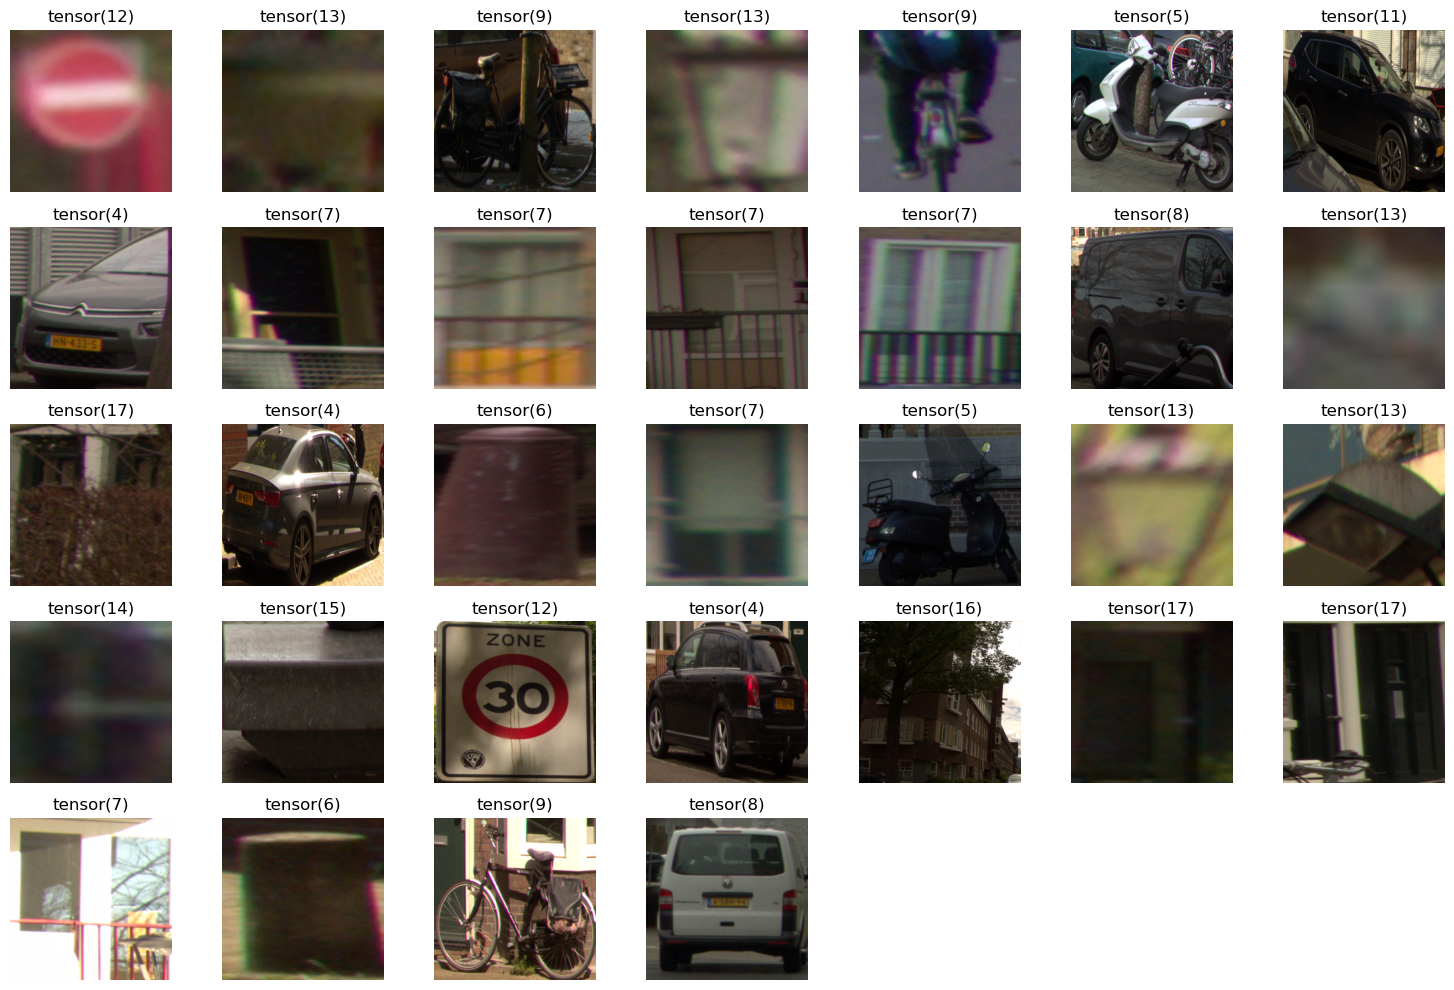

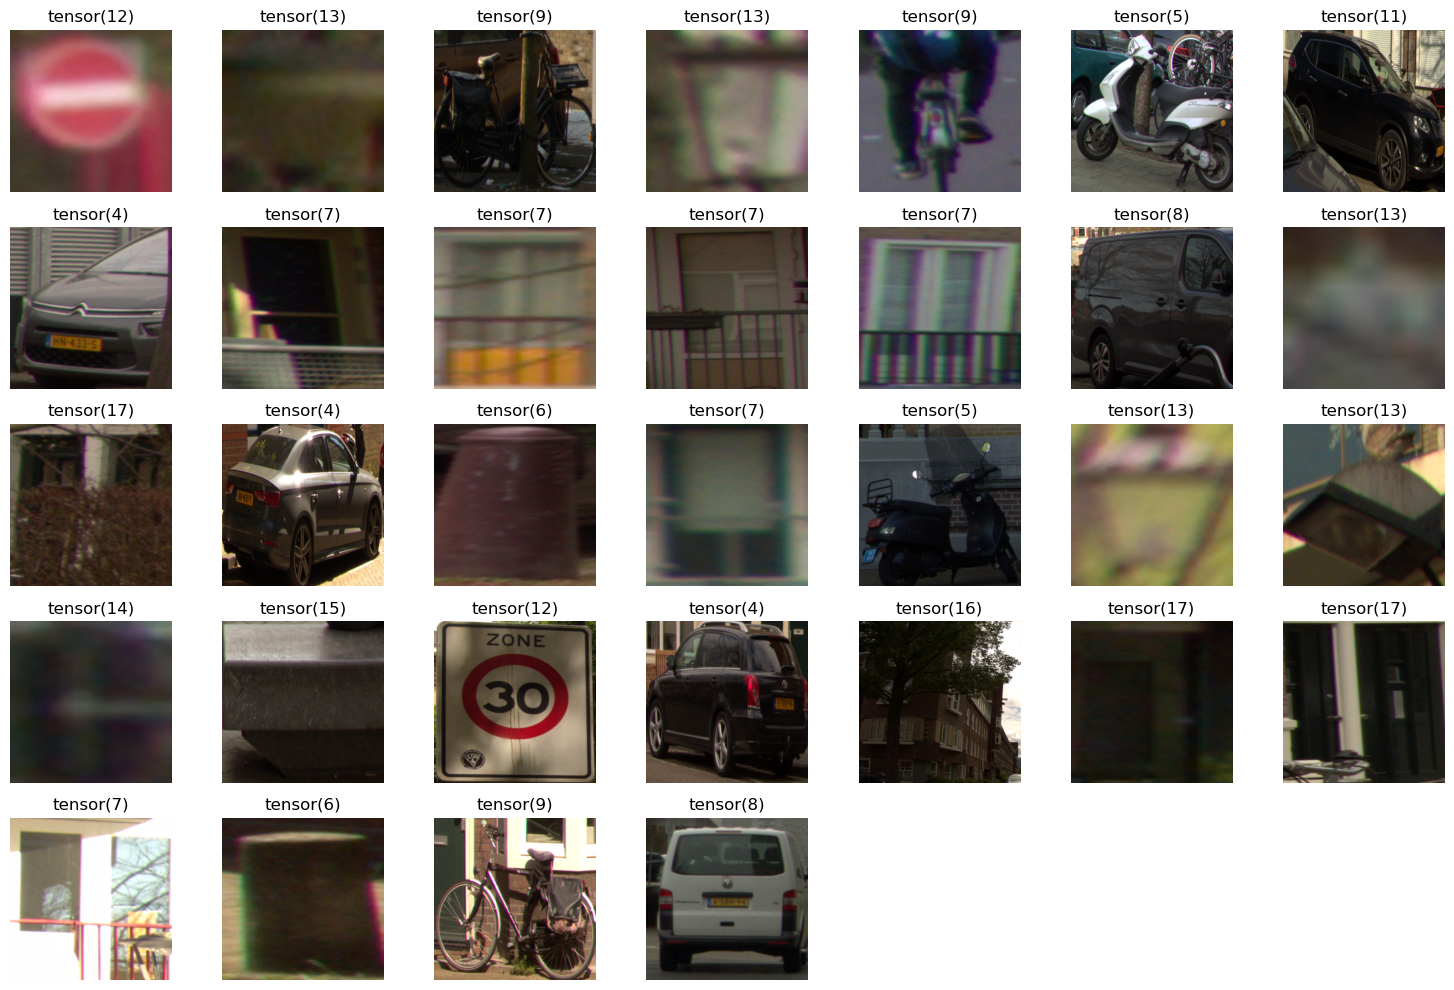

In [56]:
# print(label[0])
# unloader(img[0])
images = [unloader(img[i]) for i in range(batch_size)]
titles = [label[i] for i in range(batch_size)]

plot_images(images=images, titles=titles)

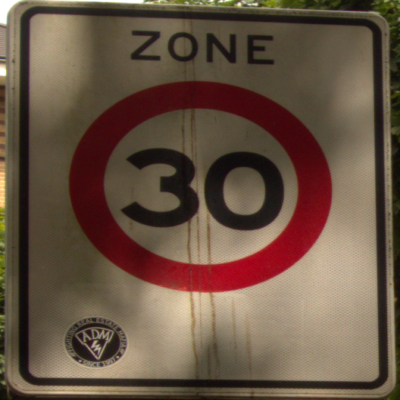

In [59]:
test_img = images[23]
test_img

40


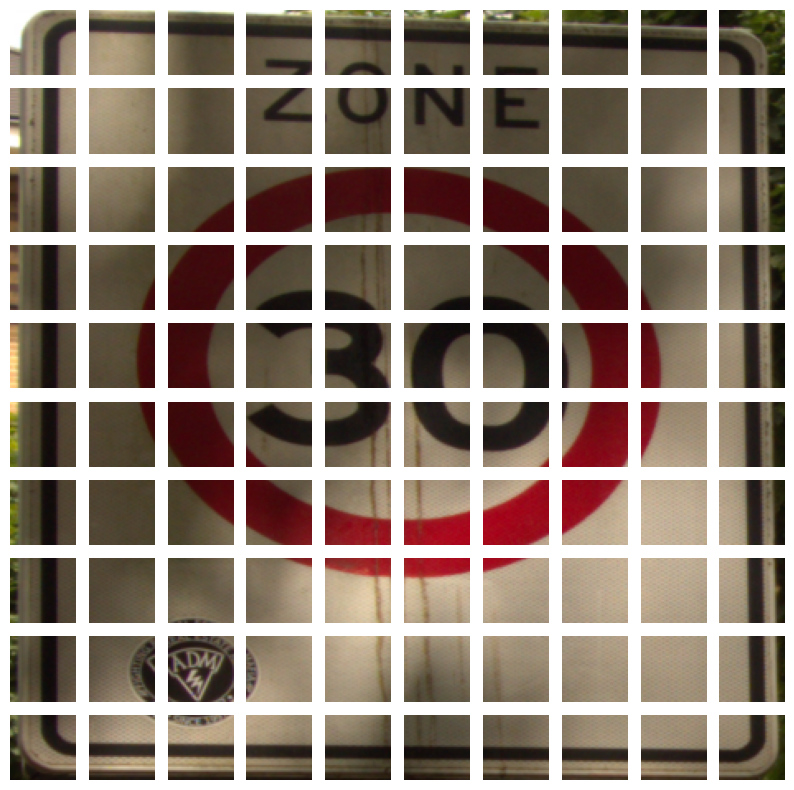

In [68]:
n = 10
fig, ax = plt.subplots(n,n, figsize=(10,10))

window_size = int(test_img.size[0] / n)
# print(window_size)

for i in range(n):
    x_window = range(window_size*i, window_size*(i+1))
    # print(window)
    for j in range(n):
        y_window = range(window_size*j, window_size*(j+1))

        # print(np.array(test_img).shape)
        crop = np.array(test_img)[x_window,:,:][:,y_window, :]

        ax[i,j].imshow(crop)
        ax[i,j].axis('off')

plt.show()


In [176]:
import sys
sys.path.append('/home/niklas/projects/pytorch-cnn-visualizations/')
from src.cnn_layer_visualization import CNNLayerVisualization
# from src.gradcam import GradCam
from src.guided_gradcam import GradCam
from src.scorecam import ScoreCam
from src.misc_functions import get_example_params, save_class_activation_images

In [73]:
models

<module 'torchvision.models' from '/home/niklas/anaconda3/envs/oads/lib/python3.9/site-packages/torchvision/models/__init__.py'>

In [87]:
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

/home/niklas/anaconda3/envs/oads/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/niklas/anaconda3/envs/oads/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [178]:
# gradcam = GradCam(models['resnet18']['rgb']['raw'], target_layer='layer4')
gradcams = {}
for model_type in models.keys():
    gradcams[model_type] = {}
    for image_representation in models[model_type].keys():
        gradcams[model_type][image_representation] = {}
        for image_quality in models[model_type][image_representation].keys():

            gradcam = GradCam(models[model_type][image_representation][image_quality], target_layer='layer4')
            gradcams[model_type][image_representation][image_quality] = gradcam

In [179]:
# gradcam = GradCam(models['resnet18']['rgb']['raw'], target_layer='layer4')
scorecmas = {}
for model_type in models.keys():
    scorecmas[model_type] = {}
    for image_representation in models[model_type].keys():
        scorecmas[model_type][image_representation] = {}
        for image_quality in models[model_type][image_representation].keys():

            scorecam = ScoreCam(models[model_type][image_representation][image_quality], target_layer='layer4')
            scorecmas[model_type][image_representation][image_quality] = scorecam

In [173]:
img, label, z = next(iter(loaders['rgb']))
img_coc, label_coc, z_coc = next(iter(loaders['coc']))

  0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'ResNet' object has no attribute 'features'

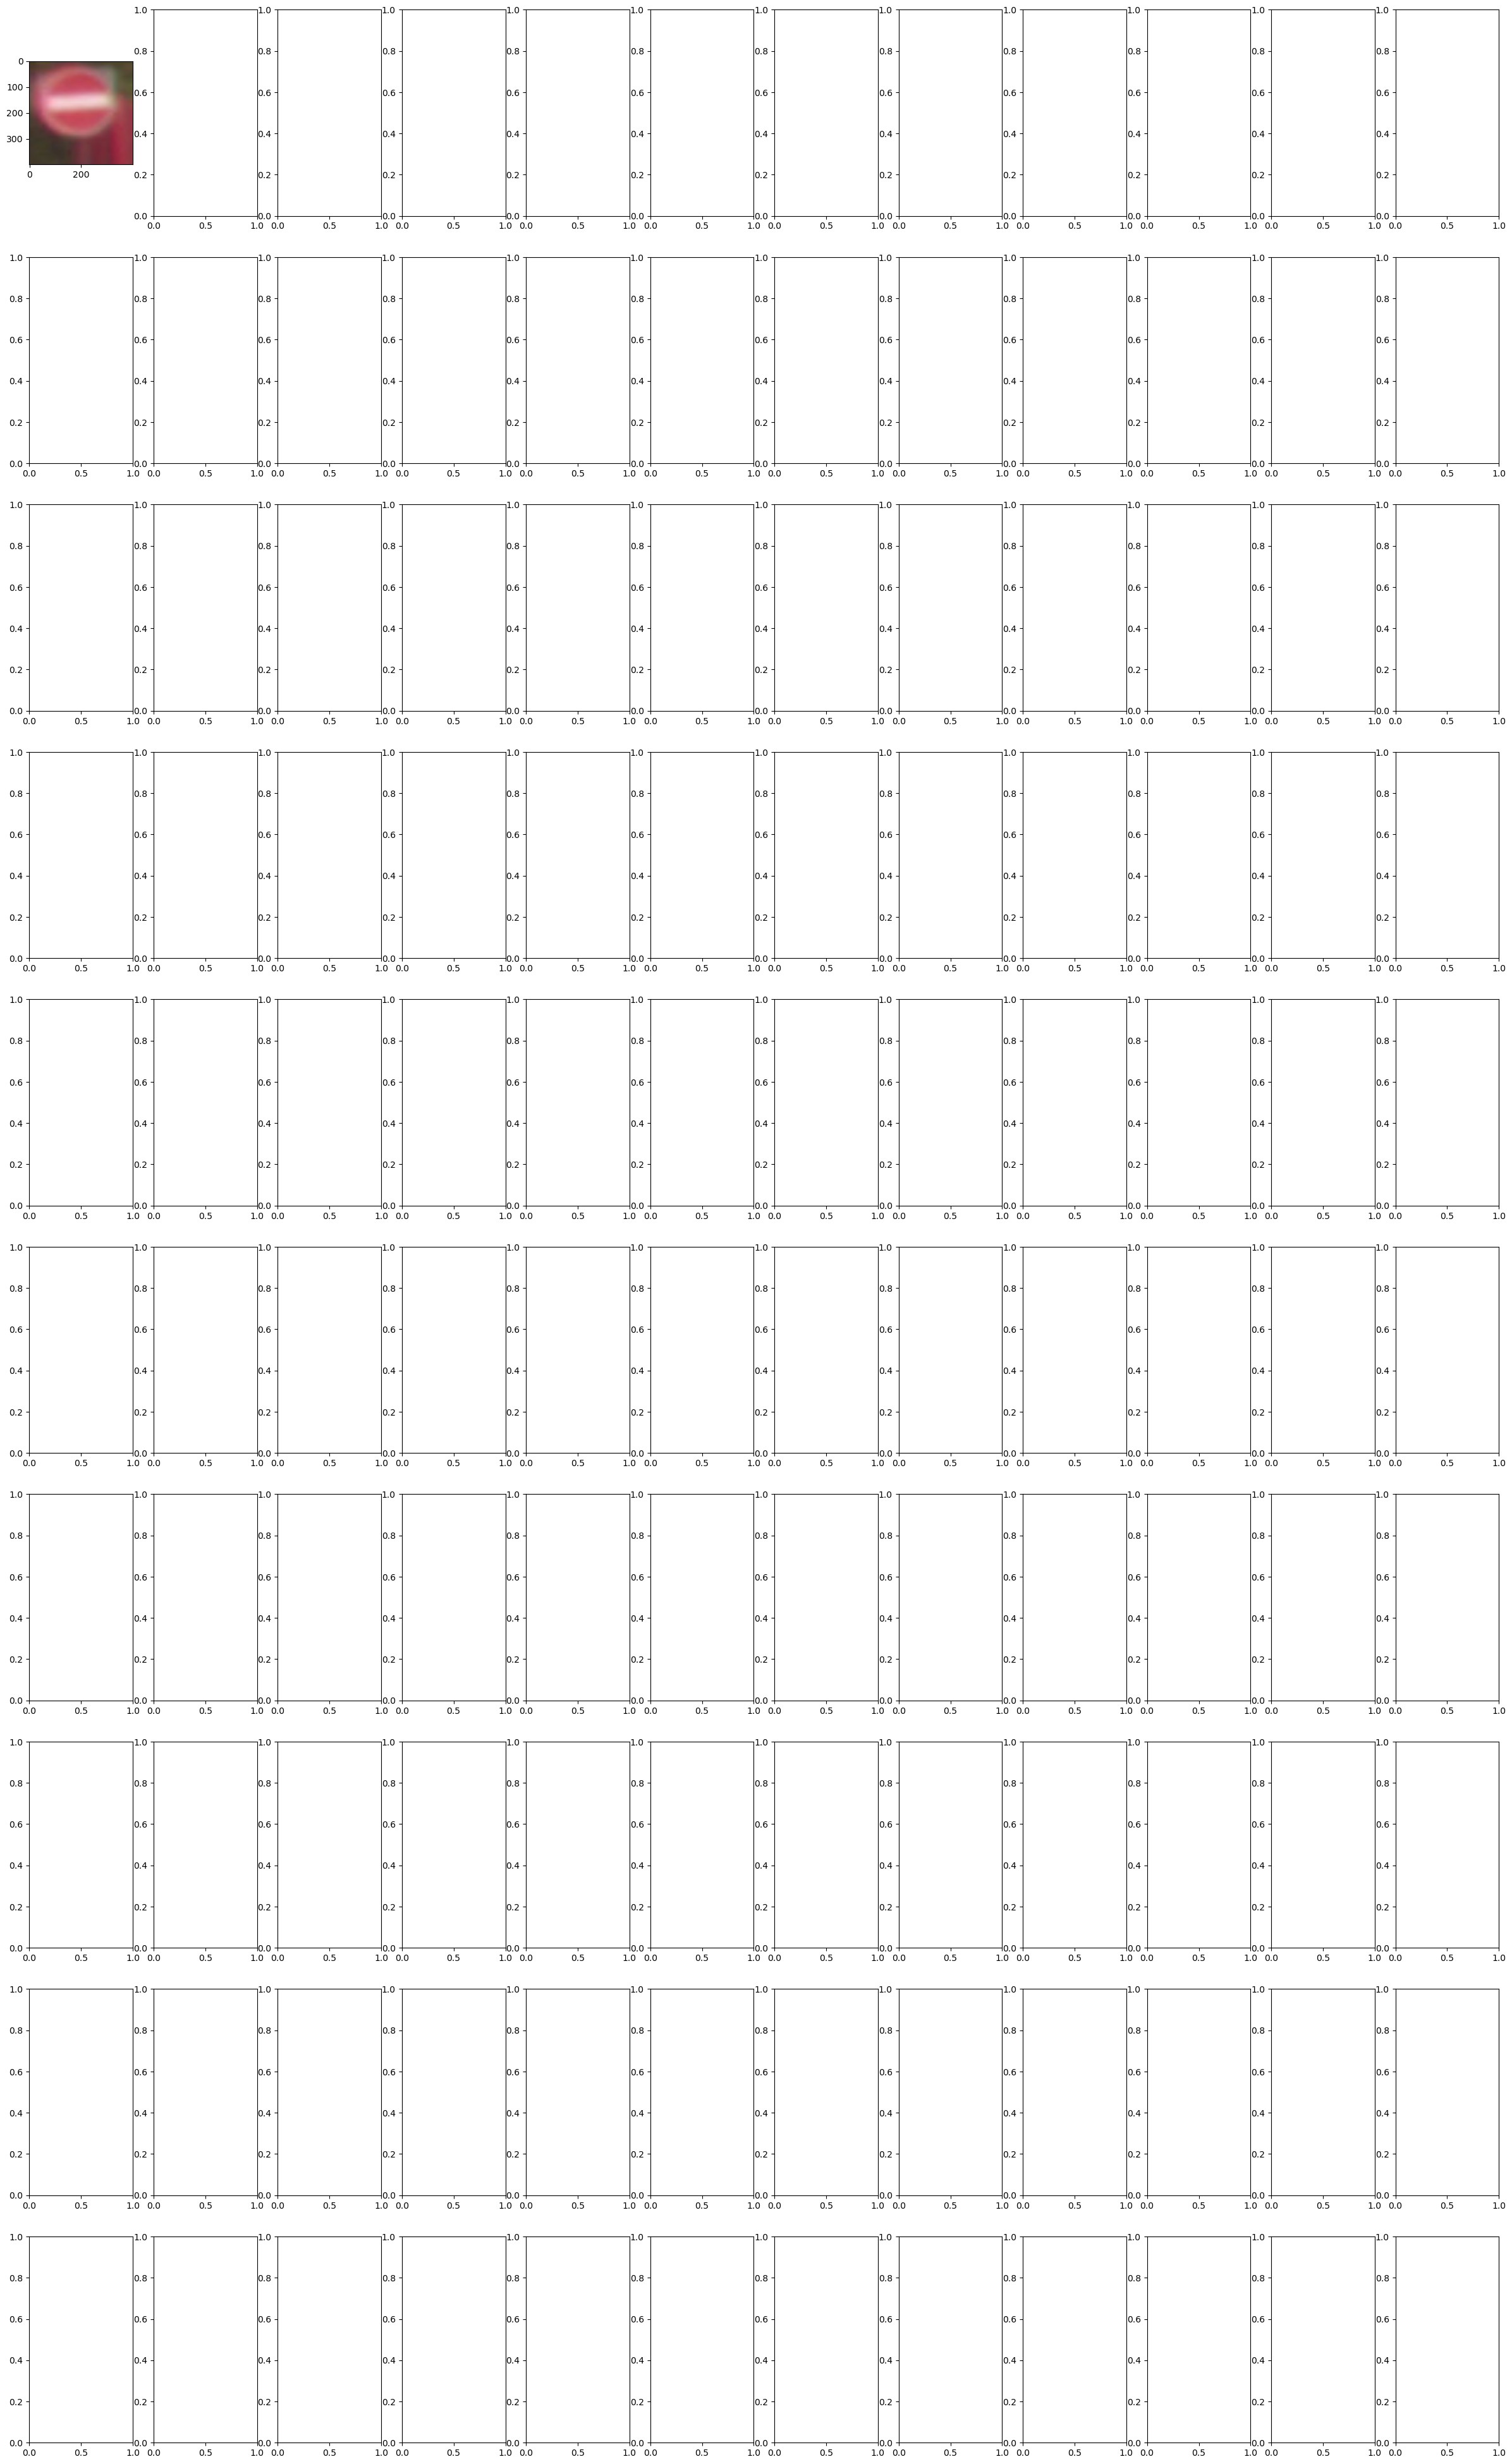

In [181]:
n = 10
fig, ax = plt.subplots(n, 12, figsize=(30,5*n))

for index in tqdm.tqdm(range(n)):
    col_ind = 0
    for model_type in models.keys():
        for image_representation in models[model_type].keys():
            for image_quality in models[model_type][image_representation].keys():

                gradcam = gradcams[model_type][image_representation][image_quality]

                if image_representation == 'rgb':
                    _img = img[index]
                elif image_representation == 'coc':
                    _img = img_coc[index]

                ax[index, col_ind].imshow(unloader(img[index]))
                ax[index, col_ind].imshow(gradcam.generate_cam(_img.unsqueeze(0)), alpha=0.5)
                # ax[index, col_ind].imshow(scorecam.generate_cam(_img.unsqueeze(0)), alpha=0.5)
                ax[index, col_ind].axis('off')

                # if index == 0:
                ax[index, col_ind].set_title(f'{model_type} {image_representation} {image_quality}')

                col_ind += 1
plt.show()